
# Data analysis of the distractor volatility on statistical learning 
In this study, we compared high- vs. low-volatility changes of the distractor occurrence in a distractor singleton search task. The distractor prevelance was 50% in both sequences. The sequences were generated with Markov chain. 


In [1]:
import scipy.io
import numpy as np
import pandas as pd 
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization
from statsmodels.formula.api import ols
from statsmodels.stats.anova import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

In [2]:
# function for distractor and target locations
##sub1-8:frequent location is [2 3 4 5 6 7 8 1]
def func_biasloc(x,y):
    if x==0:  return 'absent'
    elif x==(y%8+1):  return 'frequent'
    else:  return 'rare'
func_biasloc=np.vectorize(func_biasloc)

# def func_biasloc_tar(x,y,z):
#     if x==(y%8+1) and z==0:  return 'frequent'
#     elif x!=(y%8+1) and z==0:  return 'rare'
#     else: return 'none'
# func_biasloc_tar=np.vectorize(func_biasloc_tar)
def func_biasloc_tar(x,y,z):
    if x==(y%8+1) and z==0 :  return 'frequent'
    elif x!=(y%8+1) and z==0:  return 'rare'
    else: return 'none'
func_biasloc_tar=np.vectorize(func_biasloc_tar)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


## 1 Import data

Check the general sample population. 

In [3]:
### general infomation ###
url_info = './csv/raw_info_all.csv'
info = pd.read_csv(url_info)
gender_M = ((info['gender'] == 'M') & (info['volatility'] == 1)).sum()
gender_F = ((info['gender'] == 'F') & (info['volatility'] == 1)).sum()
age = info.query('volatility==1').age.mean().round(3)
print('Males:', gender_M, 'Females:', gender_F,  ' Mean age:', age)


Males: 9 Females: 15  Mean age: 26.542


We first read the raw data. 

In [4]:
dat = (pd.read_csv('./csv/raw_data_all2.csv')
       .assign(sub=lambda df: df['sub'].str.replace('s', '').astype(int),
               dist_pos_preced=lambda df: df["dist_pos"],
               dist_bias=lambda df: func_biasloc(df["dist_pos"], df['sub']),
               tar_bias=lambda df: func_biasloc_tar(df["tar_pos"], df['sub'], df["dist_pos"])))
# show dat dimension
print(dat.shape)
dat.head()

(69120, 17)


,Unnamed: 0,tar_pos,dist_pos,block,correct,rt,sub,volatility,dist_repe,dist_repe_absent,dist_attendance,dist_switch,coincident,Abe_Pre,dist_pos_preced,dist_bias,tar_bias
0,0,2.0,0.0,1.0,1.0,1.501370,1,high,0,1,NaN,NaN,none,absent,0.0,absent,frequent
1,1,2.0,1.0,1.0,1.0,1.000736,1,high,1,0,AP,switch,none,present,1.0,rare,none
2,2,2.0,1.0,1.0,1.0,1.368081,1,high,2,0,PP,non_switch,none,present,1.0,rare,none
3,3,2.0,0.0,1.0,1.0,0.684040,1,high,0,1,PA,switch,non-coincident,absent,0.0,absent,frequent
4,4,2.0,0.0,1.0,1.0,0.565839,1,high,0,2,AA,non_switch,none,absent,0.0,absent,frequent


### 1.1 Set outliers for individual data

We set the outliers for the individual data. The outliers were defined as the data points that were outside the [.25, .75] + 2 x IQR range, plus the reaction time (RT) that was less than 0.150 s or greater than 4 s.

In [5]:
# scale factor
sf = 2 # sf * IQR 

# First step: Calculate median, Q1, Q3, and IQR
sub_summary = (dat
               .groupby(['sub'])
               .agg(median_RT=('rt', 'median'),
                    Q1_RT=('rt', lambda x: x.quantile(0.25)),
                    Q3_RT=('rt', lambda x: x.quantile(0.75)))
               .reset_index())

# Calculate IQR
sub_summary['IQR_RT'] = sub_summary['Q3_RT'] - sub_summary['Q1_RT']

# Second step: Calculate lower and upper bounds using the calculated Q1, Q3, and IQR
sub_summary['lower_RT'] = sub_summary['Q1_RT'] - sf * sub_summary['IQR_RT']
sub_summary['upper_RT'] = sub_summary['Q3_RT'] + sf * sub_summary['IQR_RT']
# lower_RT minimum value is 0.15
sub_summary['lower_RT'] = sub_summary['lower_RT'].apply(lambda x: 0.15 if x < 0.15 else x)  
# upper_RT maximum value is 4
sub_summary['upper_RT'] = sub_summary['upper_RT'].apply(lambda x: 4 if x > 4 else x)

# Display the first few rows to verify the results
sub_summary.head()

,sub,median_RT,Q1_RT,Q3_RT,IQR_RT,lower_RT,upper_RT
0,1,0.934903,0.768110,1.201833,0.433722,0.150000,2.069278
1,2,0.617840,0.551178,0.701380,0.150202,0.250774,1.001783
2,3,0.634462,0.534604,0.751424,0.216820,0.150000,1.185065
3,4,1.001492,0.801390,1.268435,0.467045,0.150000,2.202526
4,5,1.001569,0.818152,1.285121,0.466969,0.150000,2.219060


merge the individual criteria with the raw dat, as `data`, marked those outliers ourside the defined range. 

In [6]:
# use sub_summary lower_RT and upper_RT of each subject to mark the outlier in dat

data = dat.merge(sub_summary[['sub', 'lower_RT', 'upper_RT']], on='sub')
data['outlier'] = (data['rt'] < data['lower_RT']) | (data['rt'] > data['upper_RT']) 

# calculate the percentage of outliers
outlier_percentage = (data
                      .groupby(['sub'])
                      .agg(outlier_percentage=('outlier', lambda x: x.mean() * 100))
                      .reset_index())
print(f"The outlier rate is {outlier_percentage.outlier_percentage.mean():.2f}%")

The outlier rate is 2.82%


In [35]:
print(f"error rate is {(1- data.correct.mean())*100:.2f}%")

error rate is 1.61%


In [7]:
# calculate total error and outlier rate (correct == 0 or outlier is True)
data['exclude'] = (data['correct'] < 1) | (data['outlier'] == True)
print(f"exclude rate is {data['exclude'].mean()*100:.2f}%")

exclude rate is 4.13%


## 2 Distractor interference effect

We first check the distractor interference effect, defined as the distractor presence vs. absence. For the distractor presence trials, we have two distractor locations: high vs. low probability distractor locations. This distractor conditions are defined in the column `dist_bias` (frequent, rare, absent).
In addition, we have two distractor volatility conditions: high vs. low volatility from the column `volatility` (high, low).

In [38]:
# replace rt with NA if it is exclude, it will not be included in the analysis of averaging    
data['rt'] = data['rt'].where(~data['exclude'])

# Calculate mean rt and error rate for each sub within each condition
grouped_data = (data
                .groupby(['sub', 'volatility','dist_bias'])
                .agg(mean_rt=('rt', 'mean'),
                     error_rate=('correct', lambda x: (1 - x.mean()) * 100))
                .reset_index())
# spread the grouped_data to wide format for JASP Bayesian ANOVA
mean_data = grouped_data.pivot_table(index=['sub'], columns=['volatility', 'dist_bias'], 
                         values=['mean_rt', 'error_rate'])
mean_data.columns = ['_'.join(col).strip() for col in mean_data.columns.values]
mean_data.reset_index().to_csv('./csv/mean_data.csv', index=False)

grouped_data.head()

,sub,volatility,dist_bias,mean_rt,error_rate
0,1,high,absent,0.985284,1.381215
1,1,high,frequent,1.186675,2.164502
2,1,high,rare,1.200110,1.181102
3,1,low,absent,0.847312,0.692521
4,1,low,frequent,0.968744,0.665188


In [41]:
print("Mean RT for high vs. low volatility:")
grouped_data.groupby('volatility').mean_rt.mean()

Mean RT for high vs. low volatility:


volatility
high    1.126699
low     1.002373
Name: mean_rt, dtype: float64

In [67]:
# calculate the interference effect: dist_bias as the baseline, and calculate the difference between rare and baseline, frequent and baseline, for each subj, volatility
dis_interference = (grouped_data
                .pivot_table(index=['sub', 'volatility'], columns='dist_bias', values='mean_rt')
                .reset_index()
                .assign(frequent=lambda df: (df['frequent'] - df['absent'])*1000,
                        rare=lambda df: (df['rare'] - df['absent'])*1000)
                .melt(id_vars=['sub', 'volatility'], value_vars=['frequent', 'rare'],
                      var_name='region', value_name='interference'))

dis_interference.groupby(['volatility', 'region']).interference.mean().reset_index().round(2)

,volatility,region,interference
0,high,frequent,85.77
1,high,rare,191.79
2,low,frequent,63.68
3,low,rare,137.77


In [84]:
# t-test for interference effect, separate for high and low volatility
tt1 = pg.ttest(dis_interference.query('volatility=="low" and region == "rare"').interference, 0)
tt2 = pg.ttest(dis_interference.query('volatility=="high" and region == "rare"').interference, 0)
tt3 = pg.ttest(dis_interference.query('volatility=="low" and region == "frequent"').interference, 0)
tt4 = pg.ttest(dis_interference.query('volatility=="high" and region == "frequent"').interference, 0)
## add all p-val to a list
p_val = [tt1['p-val'][0], tt2['p-val'][0], tt3['p-val'][0], tt4['p-val'][0]]
## add all cohen-d to a list
cohen_d = [tt1['cohen-d'][0], tt2['cohen-d'][0], tt3['cohen-d'][0], tt4['cohen-d'][0]]
# print the list bonferroni correction
print('p-values:')
print(pg.multicomp(p_val, method='bonf'))
print('cohen-d:')
print(cohen_d)


p-values:
(array([ True,  True,  True,  True]), array([9.15947129e-13, 6.72492318e-08, 6.11199181e-07, 7.72767206e-05]))
cohen-d:
[3.0617267293810535, 1.723380462515543, 1.514222149116487, 1.0935187856785316]


In [88]:
# paired t-test for interference effect, separate for high and low volatility
pg.ttest(dis_interference.query('volatility=="low" and region == "rare"').interference,
               dis_interference.query('volatility=="low" and region == "frequent"').interference, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.044032,23,two-sided,3.903199e-08,"[55.04, 93.14]",1.701189,3.607e+05,1.0


In [87]:
pg.ttest(dis_interference.query('volatility=="high" and region == "rare"').interference,
               dis_interference.query('volatility=="high" and region == "frequent"').interference, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.100411,23,two-sided,3.116291e-07,"[75.13, 136.91]",1.101315,5.249e+04,0.999311


Let's visualize the distractor interference effect in the RT.

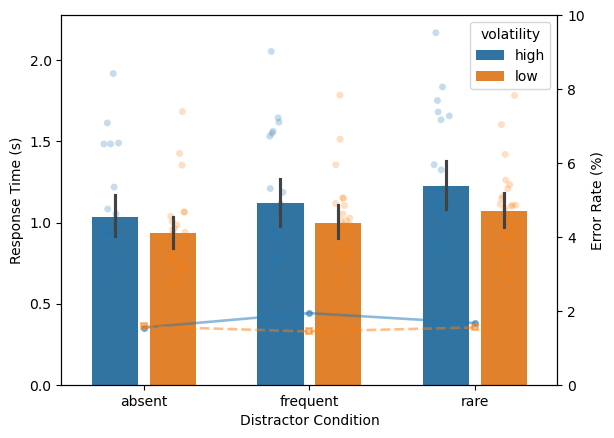

In [9]:
def plot_rt(ax):
    # initialize the plot size
    #ax.figure.set_size_inches(3.5, 3.5)
    # visualize the mean rt and error rate within one graph as scatter plot and bar plot
    sns.barplot(data=grouped_data, x='dist_bias', y='mean_rt', hue='volatility', 
                width=0.7, gap = 0.2, ax = ax)
    # add stripplot on top of the bar plot
    sns.stripplot(data=grouped_data, x='dist_bias', y='mean_rt', hue='volatility', 
                  dodge=True, alpha = .25, zorder =1, legend = False, ax = ax)
    # y-axis label: Response Time (s)
    ax.set_ylabel('Response Time (s)')
    ax.set_xlabel('Distractor Condition')    
    # add right y-axis label: Error Rate (%), without confidence interval
    ax2 = ax.twinx()
    sns.pointplot(data=grouped_data, x='dist_bias', y='error_rate', hue='volatility', markers = ['o', 's'], 
                  linestyles = ['-', '--'],  join = False, scale = 0.7, alpha = 0.5, ci = None, legend = False, ax = ax2)

    ax2.set_ylim(0, 10)
    ax2.set_ylabel('Error Rate (%)')

plot_rt(plt.gca())


In [10]:
##Statistics: global inhibition_rt
pg.rm_anova(dv='error_rate', within=['volatility','dist_bias'], subject='sub', data=grouped_data, detailed=True).round(3)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,volatility,1.382,1,23,1.382,0.301,0.588,0.588,0.003,1.000
1,dist_bias,0.401,2,46,0.201,0.338,0.715,0.705,0.001,0.954
2,volatility * dist_bias,1.747,2,46,0.874,2.447,0.098,0.104,0.004,0.894


In [11]:
pg.rm_anova(dv='mean_rt', within=['volatility','dist_bias'], subject='sub', data=grouped_data, detailed=True, effsize='np2', correction=True).round(3)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,volatility,0.556,1,23,0.556,12.655,0.002,0.002,0.355,1.000
1,dist_bias,0.654,2,46,0.327,92.987,0.000,0.000,0.802,0.856
2,volatility * dist_bias,0.018,2,46,0.009,6.152,0.004,0.010,0.211,0.746


Note for the statistics: There was no significant differences for the error rates. However, Both volatlity and distractor types and their interaction were significant for the RTs. This is likely due to the different distractor interference (high vs. low) in the high vs. low volatility conditions. 

To better understand the interaction, we use the `distractor absent` condition as the baseline, and compare the distractor interference effect defined by the difference between rare and frequent locations, in the high vs. low volatility conditions.

In [12]:
# now pivot dist_bias to columns, and calculate differences between rare and freq within each volatility and sub
prob_cueing = (grouped_data
        .pivot_table(index=['sub', 'volatility'], columns='dist_bias', values='mean_rt')
        .assign(pcue = lambda df: (df['rare'] - df['frequent'])*1000) # probablistic cueing effect
        .reset_index())
print(prob_cueing.groupby('volatility')['pcue'].mean())
prob_cueing.head()


volatility
high    106.024223
low      74.089361
Name: pcue, dtype: float64


dist_bias,sub,volatility,absent,frequent,rare,pcue
0,1,high,0.985284,1.186675,1.200110,13.434457
1,1,low,0.847312,0.968744,1.013545,44.800903
2,2,high,0.602627,0.627809,0.672436,44.626362
3,2,low,0.620850,0.642824,0.692460,49.635818
4,3,high,0.685704,0.693080,0.806546,113.465990


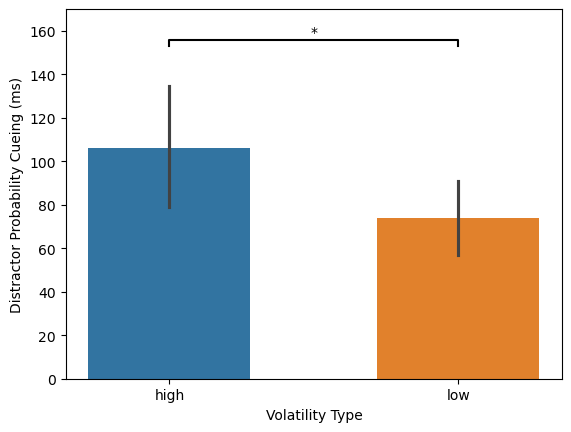

In [97]:
def plot_dcue(ax):
    # initialize the plot size
    #ax.figure.set_size_inches(3.5, 3.5)
    # visualize the mean probability cueing (`pcue`) for each volatility as bar plot
    sns.barplot(data=prob_cueing, x='volatility', y='pcue', hue = 'volatility', width = 0.7, gap = 0.2, ax=ax)
    ax.set_ylabel('Distractor Probability Cueing (ms)')
    ax.set_xlabel('Volatility Type')
    # add significance bar and annotation
    y_max = 150
    y, h, col = y_max + y_max/50, y_max/50, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((0+1)/2, y+h, "*", ha='center', va='bottom', color=col)
    ax.set_ylim(0, 170)

plot_dcue(plt.gca())


In [14]:
pg.pairwise_tests(dv ='pcue', within=['volatility'], subject='sub', 
                  data=prob_cueing, padjust='fdr_bh', effsize='cohen').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,volatility,high,low,True,True,2.35,23.0,two-sided,0.028,2.087,0.525


statistical note: the probability cueing was higher in the high volatility condition than the low volatility condition.

Next, we will examine the Target location effect, defined by the target appeared at the frequent vs. rare locations, separately for the high vs. low volatility conditions.

In [99]:
# target location was stored in the column `tar_bias`
target_location = (data.query('tar_bias != "none"') #filter out distractor present trials
                     .groupby(['sub', 'volatility', 'tar_bias'])
                     .agg(mean_rt=('rt', 'mean'))
                     .pivot_table(index=['sub', 'volatility'], columns='tar_bias', values='mean_rt')
                     .assign(ptar=lambda x: (x['frequent'] - x['rare'])*1000) # target location effect
                     .reset_index())
target_location.groupby('volatility')['ptar'].mean()

volatility
high    84.560175
low     14.522700
Name: ptar, dtype: float64

In [16]:
# statistical test of target location effect `ptar` between volatilities
pg.pairwise_ttests(dv='ptar', within='volatility', subject='sub', data=target_location, padjust='fdr_bh', effsize='cohen').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,volatility,high,low,True,True,3.539,23.0,two-sided,0.002,21.465,0.615


In [102]:
pg.ttest(target_location.query('volatility=="low"').ptar, 0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.646604,23,two-sided,0.524289,"[-31.94, 60.98]",0.131987,0.26,0.095067


In [103]:
pg.ttest(target_location.query('volatility=="high"').ptar, 0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.518449,23,two-sided,0.001843,"[34.84, 134.28]",0.7182,20.569,0.920459


In [104]:
pg.multicomp([0.524, 0.0018], method='bonf')

(array([False,  True]), array([1.    , 0.0036]))

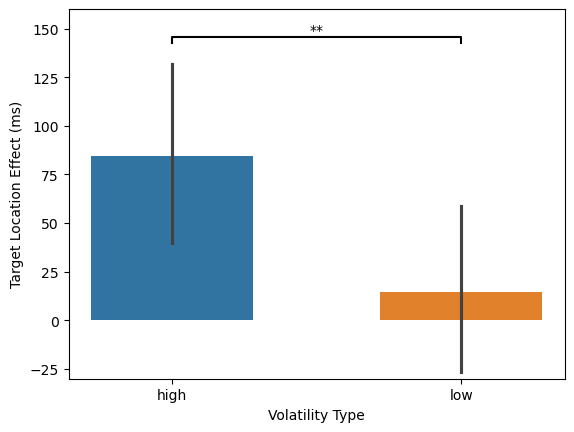

In [96]:
def plot_tloc(ax):
    # initialize the plot size
    #ax.figure.set_size_inches(3.5, 3.5)
    # visualize the `ptar` for each volatility as bar plot
    sns.barplot(data=target_location, x='volatility', y='ptar', hue = 'volatility', width = 0.7, gap = 0.2, ax = ax)
    # add stripplot on top of the bar plot
    #sns.stripplot(data=target_location, x='volatility', y='ptar', hue='volatility',  alpha = .25, zorder =1, legend = False)
    ax.set_ylabel('Target Location Effect (ms)')
    ax.set_xlabel('Volatility Type')
    # add significance bar and annotation
    y_max = 140
    y, h, col = y_max + y_max/50, y_max/50, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((0+1)/2, y+h, "**", ha='center', va='bottom', color=col)
    ax.set_ylim(-30, 160)
    


plot_tloc(plt.gca())

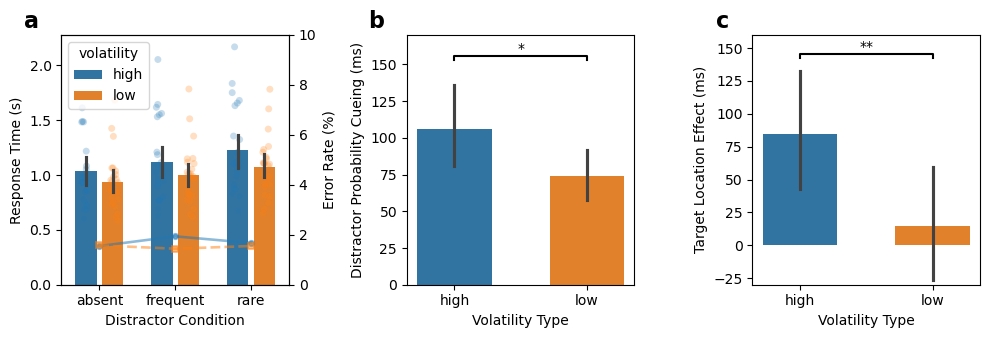

In [98]:
# combine plot_rt, plot_pcue, and plot_tloc into one figure
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
plot_rt(axes[0])
axes[0].text(-0.1, 1.1, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_dcue(axes[1])
axes[1].text(-0.1, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_tloc(axes[2])
axes[2].text(-0.1, 1.1, 'c', transform=axes[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.show()
# save the figure
fig.savefig('./figs/fig2.png', dpi=300, bbox_inches='tight')
fig.savefig('./figs/fig2.pdf', dpi=300, bbox_inches='tight')

## 3 Distrator repetition suppression effect (rt cost)  


In [19]:
# average rt for each sub, volatility, and dist_repe from data
# 
dist_rt_sub = (data.query("dist_repe < 5")
               .groupby(['sub', 'volatility','dist_repe'])
               .agg({'rt':'mean', 'correct':'count'})
               .rename(columns={'correct':'trial_count'})
               .reset_index())

# select dist_repe ==0 as baseline, and merge back to the original data (exclude dist_repe == 0)
baseline_rt = dist_rt_sub.query('dist_repe == 0').rename(columns={'rt': 'baseline_rt'}).drop(columns=['dist_repe', 'trial_count'])
dist_rt_sub = (dist_rt_sub
               .merge(baseline_rt, on=['sub', 'volatility'], how='left')
               .query('dist_repe != 0').
               assign(interference=lambda df: (df['rt'] - df['baseline_rt'])*1000))
dist_rt_sub.head().round(3)

,sub,volatility,dist_repe,rt,trial_count,baseline_rt,interference
1,1,high,1,1.218,510,0.985,233.164
2,1,high,2,1.134,155,0.985,148.383
3,1,high,3,1.097,39,0.985,111.972
4,1,high,4,1.072,9,0.985,87.182
6,1,low,1,1.071,213,0.847,224.123


In [20]:
# check grand mean of interference and the average number of trials
(dist_rt_sub.groupby(['volatility', 'dist_repe']).agg({'interference':'mean', 'trial_count':'mean'}).reset_index().round(3))

,volatility,dist_repe,interference,trial_count
0,high,1,154.933,508.125
1,high,2,51.154,152.667
2,high,3,28.622,45.875
3,high,4,63.689,11.375
4,low,1,158.302,218.375
5,low,2,81.835,163.208
6,low,3,67.519,109.875
7,low,4,49.425,73.583


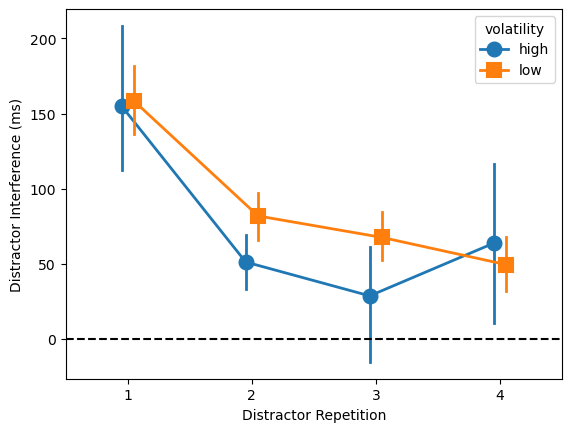

In [28]:
def plot_pcue(ax):
    # visualize the interference effect as a function of dist_repe, separated by volatility, line plot
    sns.pointplot(data=dist_rt_sub, x='dist_repe', y='interference', 
                 hue='volatility', markers=['o','s'], markersize=10, dodge = 0.1, 
                 linewidth=2, ax = ax)
    ax.set_xlabel('Distractor Repetition')
    ax.set_ylabel('Distractor Interference (ms)')
    ax.axhline(0, color='k', linestyle='--')


plot_pcue(plt.gca())

In [22]:
dist_loc_rt_l = (data.query("dist_repe > 0 and dist_repe < 5")
               .groupby(['sub', 'volatility','dist_repe','dist_bias'])
               .agg({'rt':'mean', 'correct':'count'}) # calculate mean rt and trial count
                .rename(columns={'correct':'trial_count'})
                .reset_index())
# check average number of trials
(dist_loc_rt_l.groupby(['volatility',  'dist_bias', 'dist_repe'])
 .agg({'trial_count':'mean'}).reset_index()
 .pivot_table(index=['volatility', 'dist_bias'], columns='dist_repe', values='trial_count').round(3))

dist_repe                   1        2       3       4
volatility dist_bias                                  
high       frequent   327.625   97.625  29.250   7.042
           rare       180.500   55.042  16.625   4.333
low        frequent   139.125  102.333  68.667  45.833
           rare        79.250   60.875  41.208  27.750

note: the average trial number for repetition of 4 were relatively low for the high-volatility session (7.04 and 4.33)

In [23]:

dist_loc_rt = (dist_loc_rt_l
               .drop(columns=['trial_count'])
               .pivot_table(index=['sub', 'volatility','dist_repe'], columns='dist_bias', values='rt')
               .assign(location=lambda df: (df['rare'] - df['frequent'])*1000).reset_index())
dist_loc_rt.head().round(3)

dist_bias,sub,volatility,dist_repe,frequent,rare,location
0,1,high,1,1.208,1.239,31.916
1,1,high,2,1.149,1.111,-38.376
2,1,high,3,1.084,1.120,35.232
3,1,high,4,1.105,1.018,-86.673
4,1,low,1,1.026,1.164,137.867


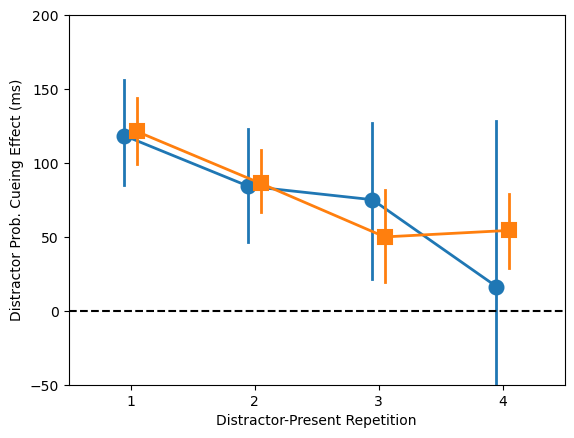

In [25]:
def plot_disrep(ax):
    # visualize the location effect as a function of dist_repe, separated by volatility, line plot
    sns.pointplot(data=dist_loc_rt, x='dist_repe', y='location', 
                  hue='volatility', markers=['o','s'], markersize=10, dodge = 0.1, 
                  linewidth=2, ax = ax, legend = False)
    ax.set_xlabel('Distractor-Present Repetition')
    ax.set_ylabel('Distractor Prob. Cueing Effect (ms)')
    # add dashed line at 0
    ax.axhline(0, color='k', linestyle='--')
    # set y-axis limit to -50 to 200
    ax.set_ylim(-50, 200)

plot_disrep(plt.gca())

In [26]:
target_loc_rt_l = (data.query("dist_repe_absent > 0 and dist_repe_absent < 5 and dist_bias == 'absent'")
               .groupby(['sub', 'volatility','dist_repe_absent','tar_bias'])
               .agg({'rt':'mean', 'correct':'count'}) # calculate mean rt and trial count
                .rename(columns={'correct':'trial_count'})
                .reset_index())
# check average number of trials
(target_loc_rt_l.groupby(['volatility', 'tar_bias', 'dist_repe_absent'])
 .agg({'trial_count':'mean'}).reset_index()
 .pivot_table(index=['volatility', 'tar_bias'], columns='dist_repe_absent', values='trial_count').round(3))


dist_repe_absent           1        2       3       4
volatility tar_bias                                  
high       frequent   95.458   26.292   7.625   2.571
           rare      412.958  122.667  36.417  10.833
low        frequent   42.083   29.042  18.500  12.750
           rare      176.000  121.625  85.958  60.042

The target repetition of 4 for the high volatlity condition at the frequent distractor location was rare, on average 2.57 trials. 

Given the average number of trials for the target location at high vol/ dist frequent locaiton is rare, we only use the repetition from 1 to 3. 

In [27]:

target_loc_rt = (target_loc_rt_l
                 .query('dist_repe_absent < 4')
                .drop(columns=['trial_count'])
               .pivot_table(index=['sub', 'volatility','dist_repe_absent'], columns='tar_bias', values='rt')
               .assign(location=lambda df: (df['frequent'] - df['rare'])*1000).reset_index())
target_loc_rt.head()

tar_bias,sub,volatility,dist_repe_absent,frequent,rare,location
0,1,high,1,0.968713,1.006274,-37.560823
1,1,high,2,0.851368,0.983339,-131.971397
2,1,high,3,0.994422,0.961247,33.174801
3,1,low,1,0.984914,0.849897,135.017022
4,1,low,2,0.813077,0.852792,-39.714991


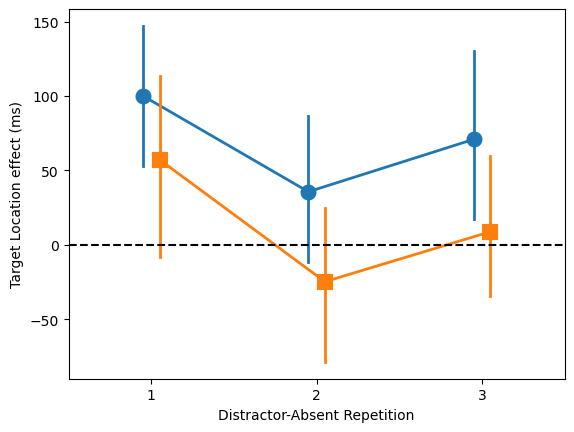

In [29]:
def plot_tarrep(ax):
    # visualize the location effect as a function of dist_repe, separated by volatility, line plot
    sns.pointplot(data=target_loc_rt, x='dist_repe_absent', y='location',
                   hue='volatility',markers=['o','s'], markersize=10, dodge = 0.1, 
                    linewidth=2, ax = ax, legend=False)
    ax.set_xlabel('Distractor-Absent Repetition')
    ax.set_ylabel('Target Location effect (ms)')
    # add dashed line at 0
    ax.axhline(0, color='k', linestyle='--')

plot_tarrep(plt.gca())

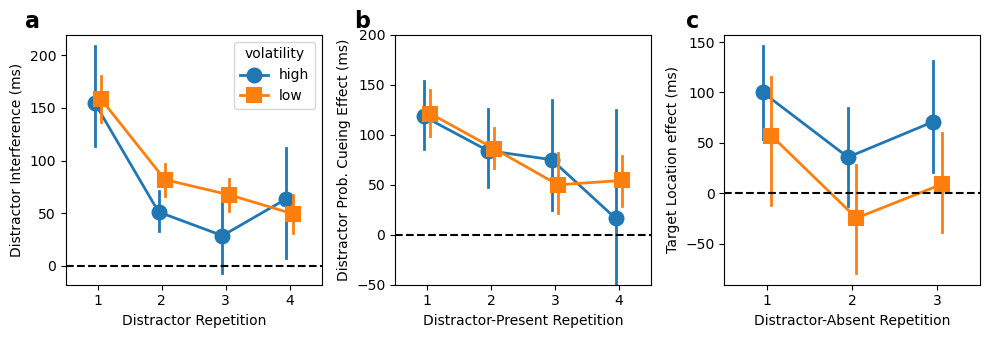

In [30]:
# combine plot_pcue, plot_disrep, and plot_tarrep into one figure
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
plot_pcue(axes[0])
axes[0].text(-0.1, 1.1, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_disrep(axes[1])
axes[1].text(-0.1, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_tarrep(axes[2])
axes[2].text(-0.1, 1.1, 'c', transform=axes[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.show()
# save the figure
fig.savefig('./figs/fig3.png', dpi=300, bbox_inches='tight')
fig.savefig('./figs/fig3.pdf', dpi=300, bbox_inches='tight')


In [ ]:
import statsmodels.api as sm
# add log scale of dist_repe_x to the dataframe
dat_rep_rt['dist_repe_x_log'] = np.log(dat_rep_rt['dist_repe_x'])
dat_rep_rt['intercept'] = 1
#  do regression of rt_cost on dist_repe_x_log, separate for for each sub, volatility
# and store slope and intercept in a dataframe
dat_rep_rt_reg = pd.DataFrame()
for sub in dat_rep_rt['sub'].unique():
    for volatility in dat_rep_rt['volatility'].unique():
        dat_sub_vol = dat_rep_rt[(dat_rep_rt['sub']==sub) & (dat_rep_rt['volatility']==volatility)]
        model = sm.OLS(dat_sub_vol['rt_cost'],dat_sub_vol[['intercept','dist_repe_x_log']])
        results = model.fit()
        dat_rep_rt_reg = dat_rep_rt_reg.append({'sub':sub,'volatility':volatility,'slope':results.params[1],'intercept':results.params[0]},ignore_index=True)
dat_rep_rt_reg.head()

In [ ]:
# draw histogram of slope, separately for each volatility type
fig_rtcost_dist_repe_slope = sns.displot(data=dat_rep_rt_reg, x='slope',hue='volatility', kind='kde', palette=colors,legend='full')

In [ ]:
# mean and standard errors of slope, separately for each volatility type
dat_rep_rt_reg.groupby('volatility').agg({'slope':['mean','sem']}).round(3)


In [ ]:
dat_rep_rt_reg.groupby('volatility').agg({'intercept':['mean','sem']}).round(3)


In [ ]:
# draw errorbar of slope, separately for each volatility type
fig_rtcost_dist_repe_slope = sns.barplot(data=dat_rep_rt_reg, x='volatility', y='slope')


In [ ]:
# run paired t-test for slope between volatility types, pair by subject
pg.pairwise_ttests(dv='slope', within=['volatility'], subject='sub', data=dat_rep_rt_reg,padjust='holm',effsize='cohen').round(3)


In [ ]:
# run paired t-test for intercept between volatility types, pair by subject
pg.pairwise_ttests(dv='intercept', within=['volatility'], subject='sub', data=dat_rep_rt_reg,padjust='holm',effsize='cohen').round(3)
